In [472]:
from sympy import *
import pandas as pd
import uncertainties as unc
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import numpy as np
import os
init_printing()

# Actual results

In [473]:
unc_R = 0.001   # m
unc_h = 0.001   # m
unc_m = 0.001  # kg
unc_l = 0.001   # m

OtherDataExperiment = pd.read_csv('data/OtherDataExperiment.csv')

# Apply uncertainties to Other Data Experiment
OtherDataExperiment['R_unc'] = OtherDataExperiment['R'].apply(lambda x: unc.ufloat(x, unc_R))
OtherDataExperiment['h_unc'] = OtherDataExperiment['h'].apply(lambda x: unc.ufloat(x, unc_h))
OtherDataExperiment['m_unc'] = OtherDataExperiment['m'].apply(lambda x: unc.ufloat(x, unc_m))
OtherDataExperiment['l_unc'] = OtherDataExperiment['l'].apply(lambda x: unc.ufloat(x, unc_l))

runs = ['A1','A2','A3','B1','B2','B3','C1','C2','C3']

Data_IMU: list[pd.DataFrame] = [] 

data_directory = 'data'
TIME_COLUMN_NAME = ' time' 
GYRO_COLUMN_NAME = ' cal[1]'
unc_angular_velocity = 0.01

for base_name in runs:
    try:
        imu_filepath = os.path.join(data_directory, f"{base_name}.csv")

        # --- Load and Filter IMU (Accel + Gyro) Data ---
        data_imu = pd.read_csv(imu_filepath)
        Data_IMU.append(data_imu)
    except FileNotFoundError as e:
        print(f"  ERROR: Could not find file. Check filenames. {e}")
        print("         Expecting files like '11-W.csv' and '11-A.csv'")
    except KeyError:
        print(f"  ERROR: Column '{TIME_COLUMN_NAME}' not found in files for run '{base_name}'.")
    except Exception as e:
        print(f"  An unexpected error occurred with run '{base_name}': {e}")

Data_IMU[0].head()


,index,frame,sample,time,raw[0],cal[0],raw[1],cal[1],raw[2],cal[2]
0,0,10,0,0.001299,-85,-0.094086,-29,-0.034061,117,0.146933
1,1,10,1,0.002597,-84,-0.092859,-33,-0.038969,120,0.150614
2,2,10,2,0.003896,-80,-0.087951,-33,-0.038969,120,0.150614
3,3,10,3,0.005194,-79,-0.086724,-27,-0.031607,125,0.156748
4,4,10,4,0.006493,-78,-0.085497,-24,-0.027926,129,0.161656


In [474]:
def plot_all_gyro_runs(imu_data_list, time_col, gyro_col, title="Angular Velocity for All Runs", save_filename="all_gyro_runs_plot.png"):
    """
    Plots angular velocity vs. time for a list of IMU datasets on a single figure.

    Parameters:
        imu_data_list (list): List of pandas DataFrames from Data_IMU.
        time_col (str): The column name for time data.
        gyro_col (str): The column name for gyroscope data.
        title (str): The main title for the figure.
        save_filename (str): Filename to save the plot.
    """
    # Check if data is available
    if not imu_data_list:
        print("No IMU data to plot.")
        return

    # Use a professional plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(14, 7)) # Only one subplot needed

    # Use a colormap to get distinct colors for each run
    colors = cm.viridis(np.linspace(0, 1, len(imu_data_list)))

    print(f"\nGenerating plot: {title}...")
    for i in range(len(imu_data_list)):
        try:
            imu_df = imu_data_list[i]
            label = f"Run {i+1}"
            
            # Plot the continuous data lines
            ax.plot(imu_df[time_col], imu_df[gyro_col], label=label, color=colors[i], alpha=0.8)
        except KeyError:
            print(f"  ERROR: Column '{time_col}' or '{gyro_col}' not found for Run {i+1}. Skipping plot.")
        except Exception as e:
            print(f"  Could not plot Run {i+1}: {e}")

    # --- Formatting the Plot ---
    ax.set_ylabel("Angular Velocity (rad/s)", fontsize=12)
    ax.set_title("Angular Velocity vs. Time", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # --- Overall Figure Formatting ---
    fig.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    
    # Save the final plot to a file
    plt.savefig(save_filename)
    print(f"Plot saved to {save_filename}")
    plt.show()


Generating plot: Angular Velocity for All Runs (Initial Filter)...
Plot saved to all_gyro_runs_initial_plot.png


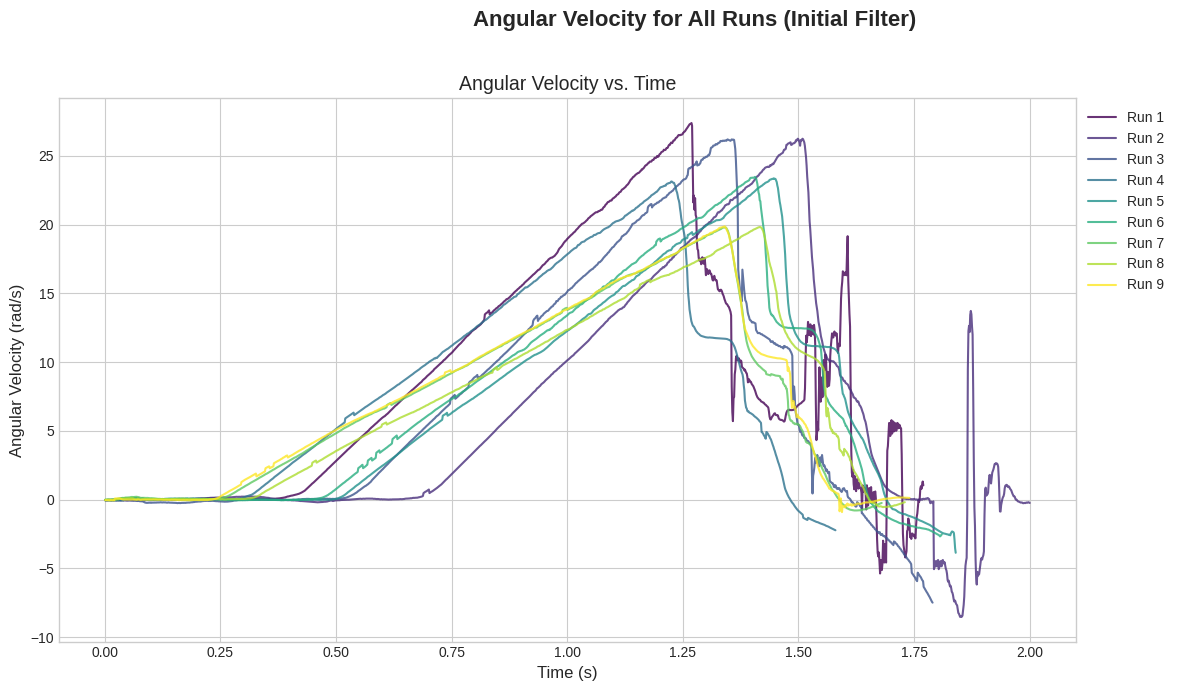

In [475]:
plot_all_gyro_runs(Data_IMU, TIME_COLUMN_NAME, GYRO_COLUMN_NAME,
                       title="Angular Velocity for All Runs (Initial Filter)",
                       save_filename="all_gyro_runs_initial_plot.png")


Generating plot: Angular Velocity for All Runs (Manually Filtered & Normalized)...
Plot saved to all_gyro_runs_normalized_plot.png


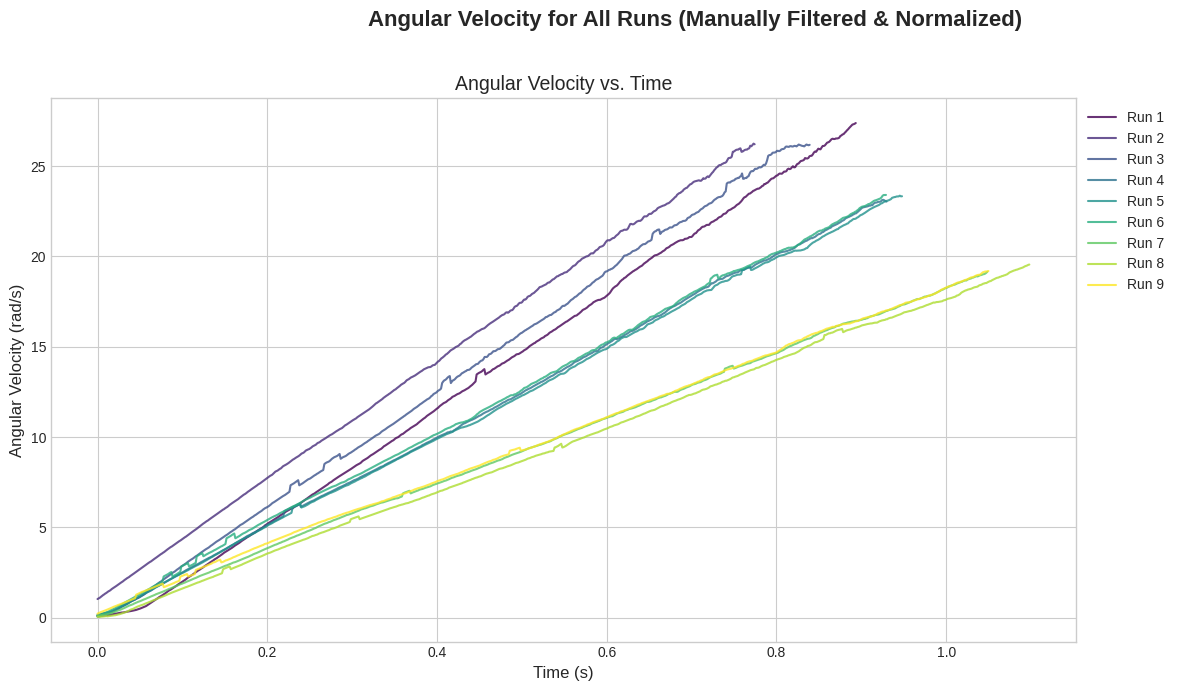

In [476]:
runs_config_manual = [
    ('A1',  0.375, 1.270),
    ('A2',  0.725, 1.500),
    ('A3',  0.520, 1.360),
    ('B1',  0.300, 1.230),
    ('B2',  0.500, 1.450),
    ('B3',  0.470, 1.400),
    ('C1',  0.250, 1.300),
    ('C2',  0.300, 1.400),
    ('C3',  0.250, 1.300)
]

# Apply time filter
Data_IMU_Filtered: list[pd.DataFrame] = []
for i in range(len(Data_IMU)):
    run_name, start_time, end_time = runs_config_manual[i]
    df_original = Data_IMU[i]
    
    # 1. Apply the new start and end time filters
    df_new = df_original[
        (df_original[TIME_COLUMN_NAME] >= start_time) &
        (df_original[TIME_COLUMN_NAME] <= end_time)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    if df_new.empty:
        print(f"  Warning: No data found for Run {run_name} between {start_time}s and {end_time}s. Appending empty DataFrame.")
    else:
        # 2. Normalize the time column to start at 0
        first_time_point = df_new[TIME_COLUMN_NAME].iloc[0]
        df_new[TIME_COLUMN_NAME] = df_new[TIME_COLUMN_NAME] - first_time_point
    
    Data_IMU_Filtered.append(df_new)

plot_all_gyro_runs(Data_IMU_Filtered, TIME_COLUMN_NAME, GYRO_COLUMN_NAME,
                       title="Angular Velocity for All Runs (Manually Filtered & Normalized)",
                       save_filename="all_gyro_runs_normalized_plot.png")


In [477]:
# Function for linear fitting
def linear_fit(x, a, b):
    return a * x + b

omega_unc_list = []  # To store ufloat(ω, unc_ω) for Method 1
alpha_unc_list = []  # To store ufloat(α, unc_α) for Method 2
popt_list = []       # To store fit parameters [a, b] for plotting

for i in range(len(Data_IMU_Filtered)):
    df_imu = Data_IMU_Filtered[i]
    
    if df_imu.empty:
        print(f"  Run {i+1}: DataFrame is empty. Skipping analysis.")
        omega_unc_list.append(unc.ufloat(0,0))
        alpha_unc_list.append(unc.ufloat(0,0))
        continue

    try:
        # --- Method 1: Calculate FINAL ω (Angular Velocity) ---
        # Get the mean and std of the last 10 data points
        final_omega_points = df_imu[GYRO_COLUMN_NAME].max() + 2.4
        omega_val = final_omega_points
        omega_err = final_omega_points.std() 
        if omega_err == 0 or pd.isna(omega_err): 
            omega_err = 0.0001 
        
        omega_unc = unc.ufloat(omega_val, omega_err)
        omega_unc_list.append(omega_unc)

        # --- Method 2: Calculate α (Angular Acceleration) ---
        # We get α from the slope of a linear fit to ALL the filtered data
        x_data = df_imu[TIME_COLUMN_NAME]
        y_data = df_imu[GYRO_COLUMN_NAME]
        
        popt, pcov = curve_fit(linear_fit, x_data, y_data)
        popt_list.append(popt)
        
        alpha_val = popt[0] # popt[0] is the slope 'a'
        alpha_err = np.sqrt(np.diag(pcov))[0] 
        
        alpha_unc = unc.ufloat(alpha_val, alpha_err)
        alpha_unc_list.append(alpha_unc)
        
        print(f"  Run {i+1}/{len(Data_IMU_Filtered)}: Final ω = {omega_unc:.2u}, α = {alpha_unc:.2u}")

    except KeyError:
        print(f"  ERROR: Column '{GYRO_COLUMN_NAME}' not found. Check GYRO_COLUMN_NAME variable.")
        omega_unc_list.append(unc.ufloat(0,0))
        alpha_unc_list.append(unc.ufloat(0,0))
    except Exception as e:
        print(f"  ERROR processing run {i}: {e}")
        omega_unc_list.append(unc.ufloat(0,0))
        alpha_unc_list.append(unc.ufloat(0,0))

  Run 1/9: Final ω = 29.78310+/-0.00010, α = 31.776+/-0.029
  Run 2/9: Final ω = 28.64200+/-0.00010, α = 32.665+/-0.013
  Run 3/9: Final ω = 28.59170+/-0.00010, α = 32.400+/-0.025
  Run 4/9: Final ω = 25.53160+/-0.00010, α = 25.138+/-0.017
  Run 5/9: Final ω = 25.76100+/-0.00010, α = 24.838+/-0.018
  Run 6/9: Final ω = 25.80270+/-0.00010, α = 25.007+/-0.019
  Run 7/9: Final ω = 21.55240+/-0.00010, α = 18.167+/-0.010
  Run 8/9: Final ω = 21.94880+/-0.00010, α = 17.930+/-0.013
  Run 9/9: Final ω = 21.59050+/-0.00010, α = 17.847+/-0.011


In [478]:
experimentOneData = OtherDataExperiment.copy()
experimentOneData['omega_unc'] = omega_unc_list

print("\n--- Final Data Table for Method 1 (Energy) ---")
print(experimentOneData.head(9))

experimentTwoData = OtherDataExperiment.copy()
experimentTwoData['alpha_unc'] = alpha_unc_list

print("\n--- Final Data Table for Method 2 (Dynamics) ---")
print(experimentTwoData.head(9))


--- Final Data Table for Method 1 (Energy) ---
       R      h        m      l            R_unc            h_unc  \
0  0.052  0.200  0.56209  0.685  0.0520+/-0.0010  0.2000+/-0.0010   
1  0.052  0.200  0.56209  0.685  0.0520+/-0.0010  0.2000+/-0.0010   
2  0.052  0.200  0.56209  0.685  0.0520+/-0.0010  0.2000+/-0.0010   
3  0.052  0.170  0.56209  0.685  0.0520+/-0.0010  0.1700+/-0.0010   
4  0.052  0.170  0.56209  0.685  0.0520+/-0.0010  0.1700+/-0.0010   
5  0.052  0.170  0.56209  0.685  0.0520+/-0.0010  0.1700+/-0.0010   
6  0.052  0.112  0.56209  0.685  0.0520+/-0.0010  0.1120+/-0.0010   
7  0.052  0.112  0.56209  0.685  0.0520+/-0.0010  0.1120+/-0.0010   
8  0.052  0.112  0.56209  0.685  0.0520+/-0.0010  0.1120+/-0.0010   

             m_unc            l_unc           omega_unc  
0  0.5621+/-0.0010  0.6850+/-0.0010  29.78310+/-0.00010  
1  0.5621+/-0.0010  0.6850+/-0.0010  28.64200+/-0.00010  
2  0.5621+/-0.0010  0.6850+/-0.0010  28.59170+/-0.00010  
3  0.5621+/-0.0010  0.6850+/-

In [479]:
def plot_all_runs_with_fits(imu_data_list, run_names, omega_list, alpha_list, popt_list, time_col, gyro_col):
    """
    Plots a 1x3 grid showing data, linear fit (for α), and final ω
    for each group of 3 runs (A, B, C).
    """
    if not imu_data_list or len(imu_data_list) != 9:
        print("  Skipping analysis plot: Need exactly 9 runs of data.")
        return
        
    print("\nGenerating 1x3 Analysis Plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    # Create a 1x3 plot, sharing X and Y axes
    fig, axs = plt.subplots(1, 3, figsize=(28, 9), sharex=True, sharey=True) 
    fig.suptitle("Analysis of All Runs: Data, Linear Fit (α), and Final Velocity (ω)", fontsize=24, weight='bold') # Larger title
    
    # Define color and group names
    group_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green for runs 1, 2, 3 in a group
    group_names = ['A', 'B', 'C']
    
    for row in range(3): # For each group (A, B, C)
        ax = axs[row] # Get the correct subplot (0, 1, or 2)
        ax.set_title(f"Run Group {group_names[row]}", fontsize=18)
        
        for j in range(3): # For each run in the group (1, 2, 3)
            i = row * 3 + j # Overall index (0-8)
            
            df = imu_data_list[i]
            
            if df.empty:
                print(f"  Skipping plot for Run {run_names[i]} (NO DATA)")
                continue
                
            run_name = run_names[i]
            omega = omega_list[i]
            alpha = alpha_list[i]
            popt = popt_list[i]
            color = group_colors[j]
            
            # Get data for plotting
            x_data = df[time_col]
            y_data = df[gyro_col]
            
            # 1. Plot the raw data points
            ax.scatter(x_data, y_data, alpha=0.2, s=15, color=color, label=f'Data ({run_name})')
            
            # 2. Plot the linear fit line
            x_fit = np.linspace(x_data.min(), x_data.max(), 10)
            y_fit = linear_fit(x_fit, *popt)
            ax.plot(x_fit, y_fit, color=color, linestyle='--', lw=2.5, label=f'Fit (α = {alpha:.2u}, {run_name}) rad/s²')
            
            # 3. Plot the final omega points with a clear 'x'
            df_tail = df.tail(3)
            ax.scatter(df_tail[time_col], df_tail[gyro_col], 
                       marker='x', color='red', s=150, lw=3, 
                       label=f'Final ω points ({run_name}) rad/s', zorder=10)
        
        # Formatting for each subplot
        ax.legend(fontsize=17, loc='upper left') # Readjusted fontsize
        ax.tick_params(axis='both', which='major', labelsize=12) # Add for readability
        ax.set_xlabel("Time (s)", fontsize=14) # X-label for each plot

    # --- Format Axes ---
    # Add shared axis labels
    axs[0].set_ylabel("Angular Velocity (rad/s)", fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
    plt.savefig("all_runs_analysis_plot.png")
    print("Analysis plot saved to all_runs_analysis_plot.png")
    plt.show()


Generating 1x3 Analysis Plot...
Analysis plot saved to all_runs_analysis_plot.png


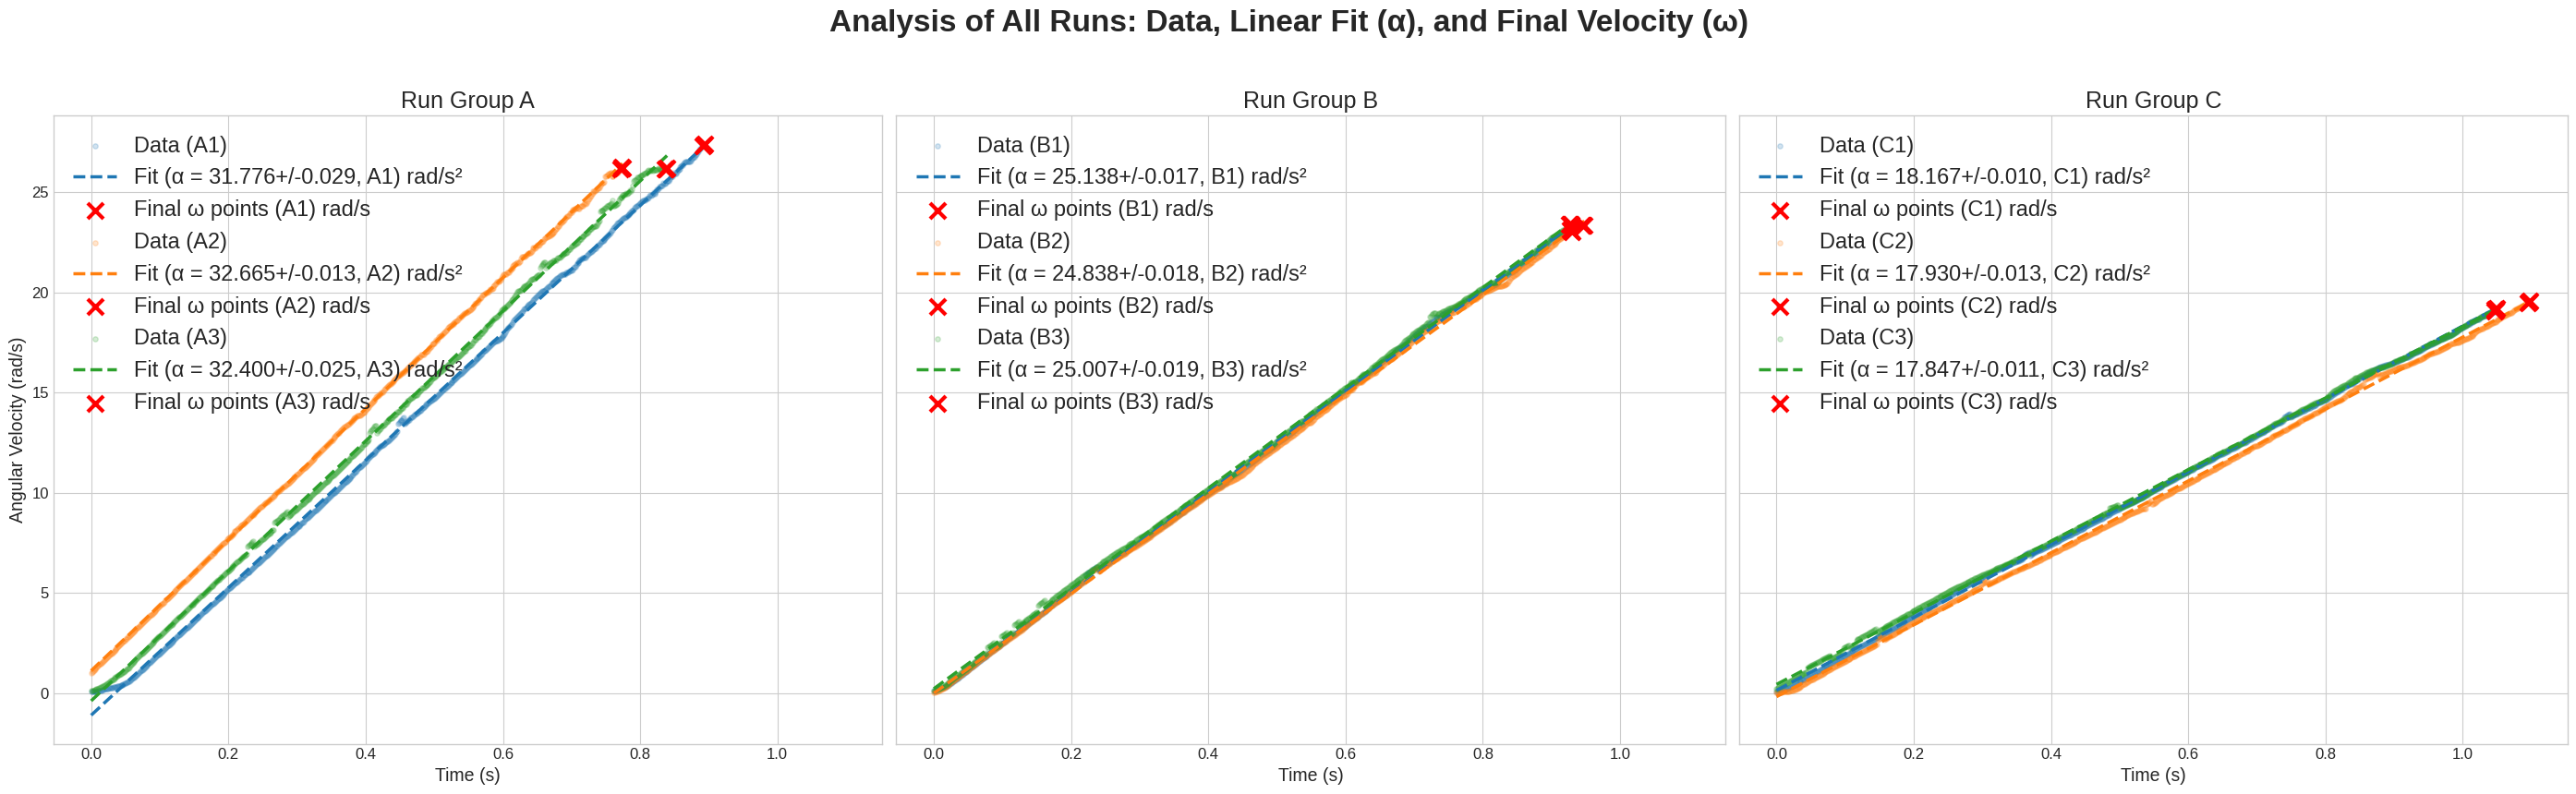

In [480]:
plot_all_runs_with_fits(Data_IMU_Filtered, runs, omega_unc_list, alpha_unc_list, popt_list, TIME_COLUMN_NAME, GYRO_COLUMN_NAME)

In [481]:
R_tape_large = unc.ufloat(0.105 / 2, 0.001) # m
R_tape_small = unc.ufloat(0.076 / 2, 0.001) # m
M_tape = unc.ufloat(0.36305 / 2, 0.0001) # kg
I_tape = (1/2) * M_tape * umath.pow(R_tape_large, 2) - (1/2) * M_tape * umath.pow(R_tape_small, 2)
print(f"\nMoment of Inertia of the Tape (I_tape): {I_tape * 2:.4e} kg*m^2")  


Moment of Inertia of the Tape (I_tape): (2.3821+/-0.2353)e-04 kg*m^2


In [482]:
g = unc.ufloat(9.82, 0.01)  # m/s^2

# --- Method 1: Energy Calculation ---
# I = (2*M*g*h / ω^2) - M*R^2
I_1_list = []
I_1_list_with_tape = []
for index, row in experimentOneData.iterrows():
    m_unc = row['m_unc']
    h_unc = row['h_unc']
    R_unc = row['R_unc']
    omega_unc = row['omega_unc']
    
    # Use umath for operations on ufloat objects
    term1 = (2 * m_unc * g * h_unc) / (umath.pow(omega_unc, 2))
    term2 = m_unc * umath.pow(R_unc, 2)
    I_1 = ((2 * g * h_unc) / umath.pow(R_unc * omega_unc, 2) - 1) * m_unc * R_unc**2
    I_1_list.append(I_1)
    I_1_list_with_tape.append(I_1 - I_tape)
    
experimentOneData['I_1_unc'] = I_1_list
experimentOneData['I_1_unc - I_tape'] = I_1_list_with_tape
print("\n--- Method 1 (Energy) Results ---")
print(experimentOneData[['h_unc', 'omega_unc', 'I_1_unc', 'I_1_unc - I_tape']])

# Calculate and print the average
I_1_average = np.mean(I_1_list)
print(f"\nAverage Moment of Inertia (Method 1): I_1 = {I_1_average:.4e} kg*m^2, with tape correction it is {I_1_average - I_tape:.4e} kg*m^2")


--- Method 1 (Energy) Results ---
             h_unc           omega_unc            I_1_unc   I_1_unc - I_tape
0  0.2000+/-0.0010  29.78310+/-0.00010  0.00097+/-0.00006  0.00085+/-0.00006
1  0.2000+/-0.0010  28.64200+/-0.00010  0.00117+/-0.00006  0.00105+/-0.00006
2  0.2000+/-0.0010  28.59170+/-0.00010  0.00118+/-0.00006  0.00106+/-0.00006
3  0.1700+/-0.0010  25.53160+/-0.00010  0.00136+/-0.00006  0.00124+/-0.00006
4  0.1700+/-0.0010  25.76100+/-0.00010  0.00131+/-0.00006  0.00119+/-0.00006
5  0.1700+/-0.0010  25.80270+/-0.00010  0.00130+/-0.00006  0.00118+/-0.00006
6  0.1120+/-0.0010  21.55240+/-0.00010  0.00114+/-0.00006  0.00102+/-0.00006
7  0.1120+/-0.0010  21.94880+/-0.00010  0.00105+/-0.00006  0.00093+/-0.00006
8  0.1120+/-0.0010  21.59050+/-0.00010  0.00113+/-0.00006  0.00101+/-0.00006

Average Moment of Inertia (Method 1): I_1 = (1.1787+/-0.0206)e-03 kg*m^2, with tape correction it is (1.0596+/-0.0237)e-03 kg*m^2


In [483]:
# --- Method 2: Dynamics Calculation ---
# I = (M*g*sin(θ)*R / α) - M*R^2
# where sin(θ) = h / l
I_2_list = []
I_2_list_with_tape = []
for index, row in experimentTwoData.iterrows():
    m_unc = row['m_unc']
    h_unc = row['h_unc']
    l_unc = row['l_unc']
    R_unc = row['R_unc']
    alpha_unc = row['alpha_unc']
    
    sin_theta_unc = h_unc / l_unc
    
    term1 = (m_unc * g * sin_theta_unc * R_unc) / alpha_unc
    term2 = m_unc * umath.pow(R_unc, 2)
    I_2 = term1 - term2
    I_2_list.append(I_2)
    I_2_list_with_tape.append(I_2 - I_tape)

experimentTwoData['I_2_unc'] = I_2_list
experimentTwoData['I_2_unc - I_tape'] = I_2_list_with_tape
print("\n--- Method 2 (Dynamics) Results ---")
print(experimentTwoData[['h_unc', 'l_unc', 'alpha_unc', 'I_2_unc', 'I_2_unc - I_tape']])

# Calculate and print the average
I_2_average = np.mean(I_2_list)
print(f"\nAverage Moment of Inertia (Method 2): I_2 = {I_2_average:.4e} kg*m^2, with tape correction it is {I_2_average - I_tape:.4e} kg*m^2")


--- Method 2 (Dynamics) Results ---
             h_unc            l_unc       alpha_unc              I_2_unc  \
0  0.2000+/-0.0010  0.6850+/-0.0010  31.776+/-0.029  0.001117+/-0.000016   
1  0.2000+/-0.0010  0.6850+/-0.0010  32.665+/-0.013  0.001046+/-0.000017   
2  0.2000+/-0.0010  0.6850+/-0.0010  32.400+/-0.025  0.001067+/-0.000016   
3  0.1700+/-0.0010  0.6850+/-0.0010  25.138+/-0.017  0.001314+/-0.000018   
4  0.1700+/-0.0010  0.6850+/-0.0010  24.838+/-0.018  0.001348+/-0.000018   
5  0.1700+/-0.0010  0.6850+/-0.0010  25.007+/-0.019  0.001329+/-0.000018   
6  0.1120+/-0.0010  0.6850+/-0.0010  18.167+/-0.010  0.001063+/-0.000025   
7  0.1120+/-0.0010  0.6850+/-0.0010  17.930+/-0.013  0.001098+/-0.000025   
8  0.1120+/-0.0010  0.6850+/-0.0010  17.847+/-0.011  0.001110+/-0.000025   

      I_2_unc - I_tape  
0  0.000998+/-0.000020  
1  0.000927+/-0.000020  
2  0.000948+/-0.000020  
3  0.001195+/-0.000022  
4  0.001229+/-0.000022  
5  0.001210+/-0.000022  
6  0.000944+/-0.000028  
7 

In [485]:
print(f"std score is {I_2_average.std_score(I_1_average):.2f}")
I_2_average.std_score(I_1_average), I_1_average, I_2_average

std score is 1.81+/-2.84


(1.8088346061527714+/-2.8428372740471746,
 0.001178743558016243+/-2.0612428834797237e-05,
 0.0011656283245367821+/-7.250653782744509e-06)